The data set was provided by https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-2019.json.zip. The dataset was in json format i had to flatten it first.There were inner records again.I have flattened the file based on the sample given in the mail.

Data set was about cyber security vulnarabilities.National vulnarabilities database is the product of the US NIST.NVD provides all the information regarding vulnarabilities.The main features i researched were about CWE codes,CVSS base score.

cwe codes refers to The Common Weakness Enumeration Specification (CWE) provides a common language of discourse for discussing, finding and dealing with the causes of software security vulnerabilities as they are found in code, design, or system architecture. Each individual CWE represents a single vulnerability type. CWE is currently maintained by the MITRE Corporation with support from the National Cyber Security Division (DHS). A detailed CWE list is currently available at the MITRE website; this list provides a detailed definition for each individual CWE.[used from NVD website]

Later, NIST provides common measure to analyse the effect of vulnarability called CVSS base score.I have taken this feature to measure the severity of the vulnarability with respect to cwe codes

The data preparation and EDA is pretty straight forward.This problem looks like unsupervised learning because there were no class lables i thought to just cluster the cwe codes based on severity i.e base score,hence i used k means clustering.The k means clustering can be prone to outliers but the feature base score was from 1-10 which means it is scaled up already.Hence i decided to go with k means.

# Data Preparation


In [1]:
from pandas.io.json import json_normalize
import pandas as pd
df = pd.read_json('/Users/Manish/Desktop/nvdcve-1.1-2019.json')

In [2]:
df.head(5)

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items
0,CVE,MITRE,4,14503,2020-03-04T08:03Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
1,CVE,MITRE,4,14503,2020-03-04T08:03Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
2,CVE,MITRE,4,14503,2020-03-04T08:03Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
3,CVE,MITRE,4,14503,2020-03-04T08:03Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4,CVE,MITRE,4,14503,2020-03-04T08:03Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."


In [3]:
#normalizing semistructured file into flat table
cv_items = json_normalize(df["CVE_Items"])

In [4]:
df = pd.concat([df.reset_index(), cv_items], axis=1)
df = df.drop(["index", "CVE_Items"], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14503 entries, 0 to 14502
Data columns (total 48 columns):
CVE_data_type                                       14503 non-null object
CVE_data_format                                     14503 non-null object
CVE_data_version                                    14503 non-null int64
CVE_data_numberOfCVEs                               14503 non-null int64
CVE_data_timestamp                                  14503 non-null object
configurations.CVE_data_version                     14503 non-null object
configurations.nodes                                14503 non-null object
cve.CVE_data_meta.ASSIGNER                          14503 non-null object
cve.CVE_data_meta.ID                                14503 non-null object
cve.data_format                                     14503 non-null object
cve.data_type                                       14503 non-null object
cve.data_version                                    14503 non-null object
cve.d

# Data cleaning

In [6]:
#dropping null values 
df = df.dropna(axis=0)

In [7]:
#Renaming the cve.CVE_data_meta.ID column
df = df.rename(columns={"cve.CVE_data_meta.ID": "cve_id"})
cve_id = df["cve_id"]
df.drop(labels=["cve_id"], axis=1,inplace = True)
df.insert(0, "cve_id", cve_id)

In [8]:
df["publishedDate"] = pd.to_datetime(df["publishedDate"])
df['lastModifiedDate']=pd.to_datetime(df['lastModifiedDate'])

# Extracting Inner Records

In [9]:
#checking for inner records
df["cve.problemtype.problemtype_data"].head(1).values[0]

[{'description': [{'lang': 'en', 'value': 'CWE-400'}]}]

In [10]:
#Getting cwe codes from cve.problemtype.problemtype_data
cwe_codes = []
cwe_index = df["cve.problemtype.problemtype_data"].index

# Running a "for" loop in order to extract and normalize the information contained with the JSON structure.
for x in df["cve.problemtype.problemtype_data"]:
    cwe_normalized_json_step_1 = json_normalize(x)
    cwe_normalized_json_step_2 = cwe_normalized_json_step_1["description"][0]
    raw_cwe_entry = json_normalize(cwe_normalized_json_step_2)["value"][0]
    clean_cwe_entry = str(raw_cwe_entry)
    cwe_codes.append(clean_cwe_entry)
    
cwe_codes = pd.Series(cwe_codes, index = cwe_index)

In [11]:
#checking for description of cwe codes
df["cve.description.description_data"].head(1).values[0]

[{'lang': 'en',
  'value': 'Receipt of a malformed packet on MX Series devices with dynamic vlan configuration can trigger an uncontrolled recursion loop in the Broadband Edge subscriber management daemon (bbe-smgd), and lead to high CPU usage and a crash of the bbe-smgd service. Repeated receipt of the same packet can result in an extended denial of service condition for the device. Affected releases are Juniper Networks Junos OS: 16.1 versions prior to 16.1R7-S1; 16.2 versions prior to 16.2R2-S7; 17.1 versions prior to 17.1R2-S10, 17.1R3; 17.2 versions prior to 17.2R3; 17.3 versions prior to 17.3R3-S1; 17.4 versions prior to 17.4R2; 18.1 versions prior to 18.1R3; 18.2 versions prior to 18.2R2.'}]

In [12]:
#extracting description from cve.description.description_data
cwe_description = []
cwe_desc_index = df["cve.description.description_data"].index

# Running a "for" loop in order to extract and normalize the information contained with the JSON structure.
for x in df["cve.description.description_data"]:
    cwe_normalized_json_step_1 = json_normalize(x)
    raw_cwe_entry_info = cwe_normalized_json_step_1["value"][0]
    clean_cwe_entry_info = str(raw_cwe_entry_info)
    cwe_description.append(clean_cwe_entry_info)
    
cwe_description = pd.Series(cwe_description, index = cwe_desc_index)

In [13]:
#setting up exploitdb_flag
count = []
count_index = df['cve.references.reference_data'].index
for x in df["cve.references.reference_data"]:
    z = json_normalize(x)
    if z['url'].any() == 'https://www.exploit-db.com/':
        count.append(1)
    else:
        count.append(0)
        

In [14]:
#converting list to a series to perform operation provided by series
count = pd.Series(count,index = count_index)

In [15]:
#setting up number of references
number_of_references = df['cve.references.reference_data'].apply(len)

In [16]:
#concatinating 
new_data = pd.concat([cwe_codes, cwe_description, number_of_references, count], axis=1)
new_data.columns = ["cwe","description", "number_of_references", "exploitdb_flag"]

In [17]:
final=df.join(new_data)

In [18]:
#preparing a final dataframe 
final_data=final[['cve_id','description','cwe','publishedDate','lastModifiedDate','impact.baseMetricV2.cvssV2.baseScore',
                  'number_of_references','exploitdb_flag']].copy()

In [19]:
#Resetting the index values 
final_data = final_data.reset_index()
final_data = final_data.drop(["index"], axis=1)

In [20]:
final_data

,cve_id,description,cwe,publishedDate,lastModifiedDate,impact.baseMetricV2.cvssV2.baseScore,number_of_references,exploitdb_flag
0,CVE-2019-0001,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15 21:29:00,2019-10-09 23:43:00,7.1,4,0
1,CVE-2019-0002,"On EX2300 and EX3400 series, stateless firewal...",CWE-20,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,3,0
2,CVE-2019-0003,When a specific BGP flowspec configuration is ...,CWE-20,2019-01-15 21:29:00,2019-10-09 23:43:00,4.3,2,0
3,CVE-2019-0004,"On Juniper ATP, the API key and the device key...",CWE-200,2019-01-15 21:29:00,2019-10-09 23:43:00,2.1,1,0
4,CVE-2019-0005,"On EX2300, EX3400, EX4600, QFX3K and QFX5K ser...",CWE-400,2019-01-15 21:29:00,2019-02-14 18:40:00,5.0,2,0
5,CVE-2019-0006,A certain crafted HTTP packet can trigger an u...,CWE-20,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,2,0
6,CVE-2019-0007,The vMX Series software uses a predictable IP ...,CWE-254,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,2,0
7,CVE-2019-0008,A certain sequence of valid BGP or IPv6 BFD pa...,CWE-119,2019-04-10 20:29:00,2019-04-15 12:31:00,7.5,2,0
8,CVE-2019-0009,"On EX2300 and EX3400 series, high disk I/O ope...",CWE-20,2019-01-15 21:29:00,2019-10-09 23:43:00,2.1,2,0
9,CVE-2019-0010,An SRX Series Service Gateway configured for U...,CWE-399,2019-01-15 21:29:00,2019-10-09 23:43:00,5.0,2,0


In [21]:
#checking for all the values of cwe codes with its count
cwe_values=final_data['cwe'].value_counts()

In [22]:
cwe_values.head(10)

CWE-79     1510
CWE-20     1376
CWE-119    1037
CWE-200     956
CWE-284     672
CWE-125     643
CWE-264     437
CWE-416     413
CWE-787     381
CWE-352     378
Name: cwe, dtype: int64

# Exploratory Data Analysis

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

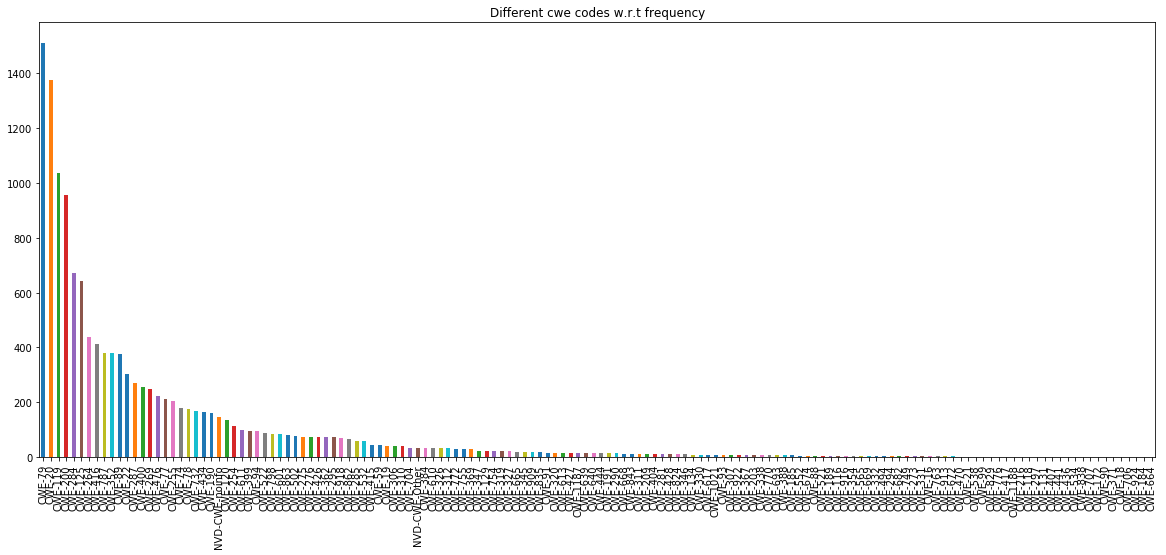

In [24]:
cwe_values.plot(kind='bar',figsize=(20,8))
plt.title("Different cwe codes w.r.t frequency")
plt.show()


we can see that most of the cwe codes occur very less and more over CWE-78,20,119 are more in number

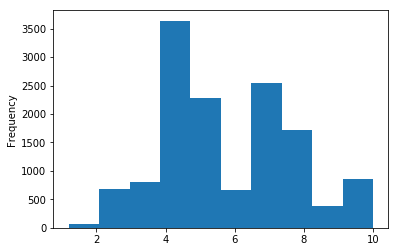

In [25]:
final_data['impact.baseMetricV2.cvssV2.baseScore'].plot(kind='hist')

I have plotted the graph cvssV2 base score with respect to frequency.we can observe that some sample of data partially normal distribution.In the below graph we can see the distribution properly

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


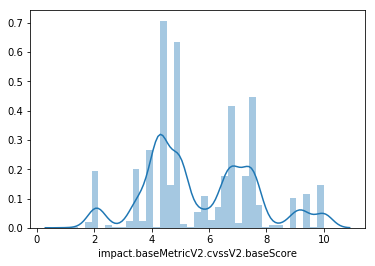

In [26]:
sns.distplot(final_data['impact.baseMetricV2.cvssV2.baseScore'])

In [27]:
#couting cwe codes and sorting them
cwe_group=final_data.groupby(['cwe']).count()['cve_id'].sort_values(ascending=False)

In [28]:
#couting base score and sorting them
cwe_mean_score=final_data.groupby(['cwe']).mean()['impact.baseMetricV2.cvssV2.baseScore'].sort_values(ascending=False)

In [29]:
#frequency cwe codes data frame which contains mean base score and cwe codes
freq_cwe_score=pd.concat([cwe_group,cwe_mean_score],axis=1,sort=True)

In [30]:
freq_cwe_score=freq_cwe_score.rename(columns={'cve_id':'count','impact.baseMetricV2.cvssV2.baseScore':'score'})

In [31]:
#sorting the dataframe wrt count
freq_cwe_score=freq_cwe_score.sort_values(by=['count'],ascending=False)

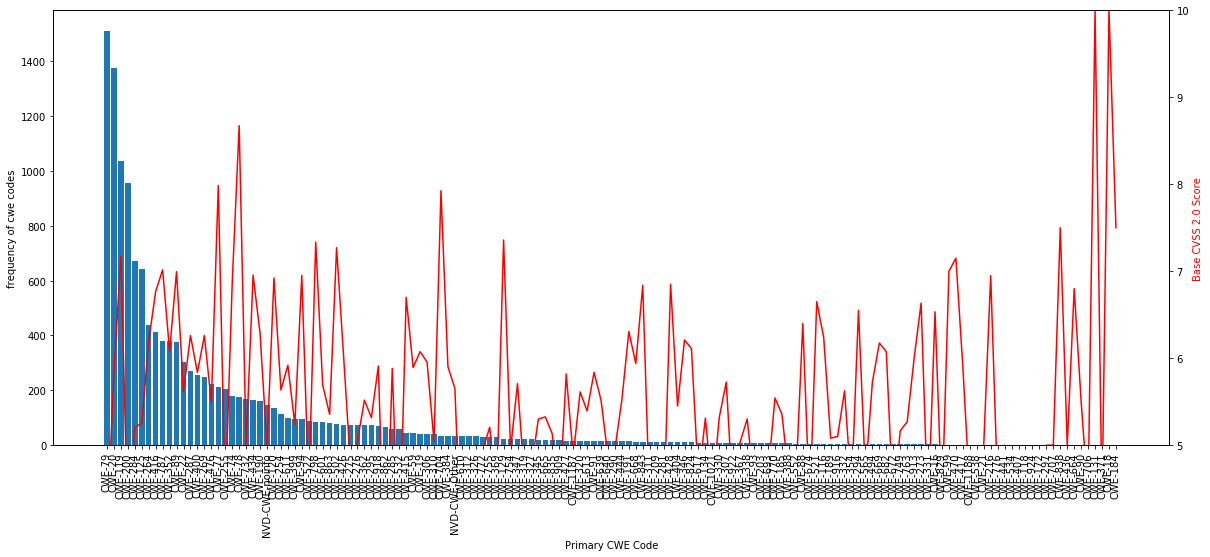

In [32]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(freq_cwe_score.index, freq_cwe_score["count"])
ax2.plot(freq_cwe_score.index, freq_cwe_score["score"], 'red')

ax1.set_xlabel('Primary CWE Code')
ax1.set_ylabel('frequency of cwe codes')
ax2.set_ylabel('Base CVSS 2.0 Score', color='red')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

I plotted this graph between cwe codes with respect to frequency of base score.we can see that the values dont differ much
i plotted to check for any trends in the vulnerability 

Since there are so many cwe codes lets take top cwe codes which show much effect.I used base score of cwe codes to determine 
the effect of vulnerabilities 

In [33]:
freq_cwe_score[freq_cwe_score['count']>99].sort_values(by=['score'],ascending=False)

,count,score
CWE-78,175,8.673143
CWE-77,213,7.985915
CWE-119,1037,7.171938
CWE-787,381,7.015486
CWE-89,375,6.995200
CWE-434,163,6.955215
CWE-120,135,6.922222
CWE-74,180,6.864444
CWE-416,413,6.769007
CWE-190,160,6.287500


NVD provides qualitative severity rankings of "Low", "Medium", and "High" for CVSS v2.0 base score ranges in addition to the severity ratings for CVSS v3.0 as they are defined in the CVSS v3.0 specification.

CVSS v2.0 Ratings

Low	0.0-3.9	
Medium	4.0-6.9	
High	7.0-10.0

# This piece of code i used to get the descriptions of each CWE codes provided by https://nvd.nist.gov/vuln/categories

In [34]:
#used for webscrapping 
from bs4 import BeautifulSoup
import lxml.etree
import requests
from urllib.request import urlopen


In [35]:
# loading the NVD CWE Definitions page and scraping it for the first table that appears
nvd_cwe_description_url = requests.get("https://nvd.nist.gov/vuln/categories")
CWE_definitions_page_soup =  BeautifulSoup(nvd_cwe_description_url.content, "html5lib")
table = CWE_definitions_page_soup.find_all('table')[0] 
cwe_definitions = pd.read_html(str(table))[0]

In [36]:
#information regarding cwe_78
cwe_78_info=cwe_definitions[cwe_definitions['Name']=='CWE-78'][["CWE-ID","Description"]].iloc[0]

In [37]:
print(cwe_78_info[0])
print("-"*10)
print(cwe_78_info[1])

Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
----------
The software constructs all or part of an OS command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended OS command when it is sent to a downstream component.


In [38]:
#information regarding cwe_119
cwe_119_info=cwe_definitions[cwe_definitions['Name']=='CWE-119'][["CWE-ID","Description"]].iloc[0]

In [39]:
print(cwe_119_info[0])
print("-"*10)
print(cwe_119_info[1])

Improper Restriction of Operations within the Bounds of a Memory Buffer
----------
The software performs operations on a memory buffer, but it can read from or write to a memory location that is outside of the intended boundary of the buffer.


In [40]:
#information regarding cwe_787
cwe_787_info=cwe_definitions[cwe_definitions['Name']=='CWE-787'][["CWE-ID","Description"]].iloc[0]

In [41]:
print(cwe_787_info[0])
print("-"*10)
print(cwe_787_info[1])

Out-of-bounds Write
----------
The software writes data past the end, or before the beginning, of the intended buffer.


# Modelling 

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [43]:
clustering_features = final_data[["cwe","impact.baseMetricV2.cvssV2.baseScore"]]

In [44]:
#converting cwe codes to numeric codes this can be thought of feature engineering 
clustering_features = pd.get_dummies(clustering_features)

In [45]:
clustering_features = clustering_features.apply(pd.to_numeric, errors='coerce')

In [46]:
# i have chosen k value from 2 to 10 because of computation limitations sinces there are 13k features and to check with every
#value is resource consuming 
k_values = range(2, 11, 1)
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, clustering_features) for k in k_values]

In [47]:
# Display all of the possible k values and associated errors
list(zip(k_values, errors_per_k))

[(2, 0.4802673911376181),
 (3, 0.4259872238339529),
 (4, 0.349907618134765),
 (5, 0.28618498408172627),
 (6, 0.2999771054789538),
 (7, 0.22802731990557848),
 (8, 0.2496847961513174),
 (9, 0.25806196563146205),
 (10, 0.28098647222317985)]

The silhouette_score with respect to cluster is identified.More the value better the model works.Here 2 and 3 are relative high among all.i have chosen 3 because not to overfit the model

In [48]:
#initialzing my model with 6 clusters
kmeans_3 = KMeans(n_clusters = 3, random_state = 0)
predictions_clusters = kmeans_3.fit_predict(clustering_features)

In [49]:
import numpy as np
np.unique(predictions_clusters, return_counts=True)

(array([0, 1, 2]), array([6359, 5743, 1551], dtype=int64))

In [50]:
predictions_clusters=predictions_clusters+1 #to eliminate Oth cluster term

In [51]:
len(predictions_clusters)

13653

In [52]:
predicted_clusters = pd.DataFrame(predictions_clusters)
predicted_clusters = predicted_clusters.rename(columns={0: "Cluster"})

In [53]:
predicted_clusters["Cluster"].value_counts().sort_index()

1    6359
2    5743
3    1551
Name: Cluster, dtype: int64

In [54]:
#cwe cluster contains the data of final data dataframe but cluster associated with it.
cwe_clusters = final_data.join(predicted_clusters)


In [55]:
cwe_cvss_count = cwe_clusters.groupby("Cluster").mean()["impact.baseMetricV2.cvssV2.baseScore"].sort_values(ascending=False)

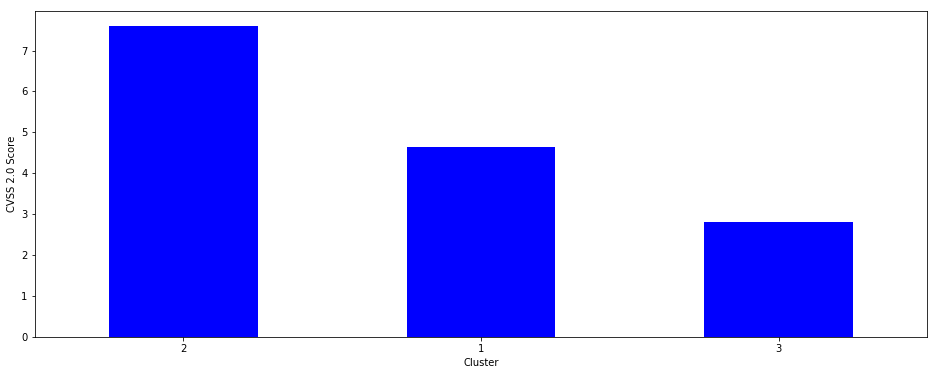

In [56]:
fig = cwe_cvss_count.plot(kind="bar", figsize = (16,6), color = "b")
fig.set_ylabel('CVSS 2.0 Score');

for tick in fig.get_xticklabels():
    tick.set_rotation(0)

Finally i can see that most of the cyber security vulnarabilities are in cluster 2.

In [61]:
cwe_clusters[cwe_clusters['Cluster']==2]

,cve_id,description,cwe,publishedDate,lastModifiedDate,impact.baseMetricV2.cvssV2.baseScore,number_of_references,exploitdb_flag,Cluster
0,CVE-2019-0001,Receipt of a malformed packet on MX Series dev...,CWE-400,2019-01-15 21:29:00,2019-10-09 23:43:00,7.1,4,0,2
1,CVE-2019-0002,"On EX2300 and EX3400 series, stateless firewal...",CWE-20,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,3,0,2
5,CVE-2019-0006,A certain crafted HTTP packet can trigger an u...,CWE-20,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,2,0,2
6,CVE-2019-0007,The vMX Series software uses a predictable IP ...,CWE-254,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,2,0,2
7,CVE-2019-0008,A certain sequence of valid BGP or IPv6 BFD pa...,CWE-119,2019-04-10 20:29:00,2019-04-15 12:31:00,7.5,2,0,2
16,CVE-2019-0017,"The Junos Space application, which allows Devi...",CWE-434,2019-01-15 21:29:00,2019-10-09 23:43:00,6.5,1,0,2
19,CVE-2019-0020,Juniper ATP ships with hard coded credentials ...,CWE-798,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,1,0,2
21,CVE-2019-0022,Juniper ATP ships with hard coded credentials ...,CWE-798,2019-01-15 21:29:00,2019-10-09 23:43:00,7.5,1,0,2
33,CVE-2019-0035,"When ""set system ports console insecure"" is en...",CWE-255,2019-04-10 20:29:00,2019-10-09 23:43:00,7.2,1,0,2
34,CVE-2019-0036,When configuring a stateless firewall filter i...,CWE-254,2019-04-10 20:29:00,2019-10-09 23:43:00,7.5,1,0,2


Hence CWE-400,CWE-20,CWE-254,CWE-119 etc vulnarabilities have high impact on severity 